# EDA for Football Player Injury Classification

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', 500)


print("Libraries Loaded Successfully.")

Libraries Loaded Successfully.


In [23]:
file_path = 'dataset.csv'
data = pd.read_csv(file_path)
data.head(3)

,Player,Player ID,Season,Injury,From,Until,Days Out,Games Missed,Club_injuries,Competition,Appearances,Club_stats,Minutes Played
0,Eldin Jakupović,2857,22/23,Leg injury,"Apr 13, 2023","May 8, 2023",25 days,5,Los Angeles FC,CONCACAF Champions Cup,-,CONCACAF CL,-
1,Eldin Jakupović,2857,22/23,Leg injury,"Apr 13, 2023","May 8, 2023",25 days,5,Los Angeles FC,Premier League,-,Premier League,-
2,James Milner,3333,24/25,Hamstring injury,"Aug 31, 2024","Sep 14, 2024",14 days,2,Brighton & Hove Albion,Premier League,3,Premier League,172'


In [24]:
uid_list = data['Player ID'].unique()
uid_map = []
for idx, uid_player in enumerate(uid_list):
    # Players in UID, length should not exceed 1 for being UID 
    players_uid = data.loc[data['Player ID']==uid_player]['Player'].unique()
    if len(players_uid)>1:
        print(f"Player ID:{uid_player} maps more than 1 player:{players_uid}")
    uid_map.append([uid_player, players_uid[0]])
uid_map_df = pd.DataFrame(columns=['Player ID', 'Player'], data=uid_map)
uid_map_df.head(10)

,Player ID,Player
0,2857,Eldin Jakupović
1,3333,James Milner
2,3455,Zlatan Ibrahimović
3,6442,Antonio Rosati
4,7093,Francesco Magnanelli
5,7161,Jonas Hofmann
6,7663,Joaquín
7,7825,Pepe Reina
8,8176,Oier Olazábal
9,8198,Cristiano Ronaldo


In [25]:
# Initial Inspection
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98338 entries, 0 to 98337
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Player          98338 non-null  object
 1   Player ID       98338 non-null  int64 
 2   Season          98338 non-null  object
 3   Injury          98338 non-null  object
 4   From            98326 non-null  object
 5   Until           97626 non-null  object
 6   Days Out        98338 non-null  object
 7   Games Missed    98338 non-null  object
 8   Club_injuries   98338 non-null  object
 9   Competition     97632 non-null  object
 10  Appearances     97636 non-null  object
 11  Club_stats      97636 non-null  object
 12  Minutes Played  97636 non-null  object
dtypes: int64(1), object(12)
memory usage: 9.8+ MB


In [26]:
data.describe()

,Player ID
count,98338.00
mean,268821.23
std,195340.20
min,2857.00
25%,111961.00
50%,226973.00
75%,377042.00
max,1292650.00


In [27]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)
# Check for duplicates
duplicates = data.duplicated().sum()
print(f"Number of Duplicates: {duplicates}")
# Remove duplicates
data.drop_duplicates(inplace=True)
print("Duplicates removed.")

Missing Values:
 Player              0
Player ID           0
Season              0
Injury              0
From               12
Until             712
Days Out            0
Games Missed        0
Club_injuries       0
Competition       706
Appearances       702
Club_stats        702
Minutes Played    702
dtype: int64
Number of Duplicates: 128
Duplicates removed.


In [28]:
# Convert date columns to datetime format if applicable
date_columns = ['From', 'Until']
for col in date_columns:
    if col in data.columns:
        data[col] = pd.to_datetime(data[col], errors='coerce')

print("Data Type Correction Completed.")

Data Type Correction Completed.


In [29]:
# Competition column is dirty and have very high cardinality like more than 500 unique competition.
# 'Until' column is not needed since we have 'Days Out' column.
data.drop(columns=['Competition', 'Until'],inplace=True)
# 'Club_injuries' is actually the club of the player during injury
data = data.rename(columns=
    {
        'Club_injuries':'Club',
        'Club_stats': 'League'
    })

In [30]:
data.dtypes

Player                    object
Player ID                  int64
Season                    object
Injury                    object
From              datetime64[ns]
Days Out                  object
Games Missed              object
Club                      object
Appearances               object
League                    object
Minutes Played            object
dtype: object

In [31]:
# Flag Rows with Missing Injury Data
data['is_injurydata_missing'] = data.loc[
    (data['Appearances'].isna()) &
    (data['League'].isna()) &
    (data['Minutes Played'].isna())
].index.to_series().apply(lambda x: True)
data['is_injurydata_missing'].fillna(False, inplace=True)
print("Flagged rows with missing injury data.")

Flagged rows with missing injury data.


C:\Users\Furka\AppData\Local\Temp\ipykernel_14552\860960485.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['is_injurydata_missing'].fillna(False, inplace=True)
C:\Users\Furka\AppData\Local\Temp\ipykernel_14552\860960485.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['is_injurydata_missing'].

In [32]:
data['League'] = data['League'].fillna('UNKNOWN') 
data['Days Out'] = data['Days Out'].str.extract(r'(\d+)').astype(float)
data['Games Missed'] = pd.to_numeric(data['Games Missed'], errors='coerce')
data['Minutes Played'] = data['Minutes Played'].replace('-', '0').str.extract(r'(\d+)').astype(float).fillna(-1)
data['Appearances'] = data['Appearances'].replace('-', 0).astype(float).fillna(-1)

In [33]:
data.dtypes

Player                           object
Player ID                         int64
Season                           object
Injury                           object
From                     datetime64[ns]
Days Out                        float64
Games Missed                    float64
Club                             object
Appearances                     float64
League                           object
Minutes Played                  float64
is_injurydata_missing              bool
dtype: object

In [34]:
# Analyze missing values by data type
categorical_columns = data.select_dtypes(include=['object']).columns
numerical_columns = data.select_dtypes(include=['number']).columns
datetime_columns = data.select_dtypes(include=['datetime']).columns

# Inspect missing values in each type
print("Missing Values in Categorical Columns:")
print(data[categorical_columns].isnull().sum())

print("\nMissing Values in Numerical Columns:")
print(data[numerical_columns].isnull().sum())

print("\nMissing Values in Date Columns:")
print(data[datetime_columns].isnull().sum())

Missing Values in Categorical Columns:
Player    0
Season    0
Injury    0
Club      0
League    0
dtype: int64

Missing Values in Numerical Columns:
Player ID            0
Days Out            12
Games Missed      5871
Appearances          0
Minutes Played       0
dtype: int64

Missing Values in Date Columns:
From    12
dtype: int64


In [35]:
data = data.dropna(subset=['From'])

In [50]:
# We only have missing values on Game Missed column. 
data.isna().sum()

Player                      0
Player ID                   0
Season                      0
Injury                      0
From                        0
Days Out                    0
Games Missed             5859
Club                        0
Appearances                 0
League                      0
Minutes Played              0
is_injurydata_missing       0
dtype: int64

In [51]:
# Ratio of raws with nan
100*data['Games Missed'].isna().sum()/data.shape[0]

5.966516629666592

In [39]:
data.loc[data['Games Missed'].isna()]

,Player,Player ID,Season,Injury,From,Days Out,Games Missed,Club,Appearances,League,Minutes Played,is_injurydata_missing
249,Cristiano Ronaldo,8198,23/24,unknown injury,2024-01-23,19.00,NaN,Unknown,4.00,King's Cup,412.00,False
250,Cristiano Ronaldo,8198,23/24,unknown injury,2024-01-23,19.00,NaN,Unknown,31.00,Saudi Pro League,2.00,False
251,Cristiano Ronaldo,8198,23/24,unknown injury,2024-01-23,19.00,NaN,Unknown,1.00,Saudi Super Cup,86.00,False
252,Cristiano Ronaldo,8198,23/24,unknown injury,2024-01-23,19.00,NaN,Unknown,8.00,AFC Champions League,738.00,False
253,Cristiano Ronaldo,8198,23/24,unknown injury,2024-01-23,19.00,NaN,Unknown,1.00,AFC CL-Qualification,90.00,False
...,...,...,...,...,...,...,...,...,...,...,...,...
98252,Jastin García,1061665,24/25,Shoulder injury,2024-07-23,92.00,NaN,Unknown,0.00,LaLiga,0.00,False
98253,Jastin García,1061665,24/25,Shoulder injury,2024-07-23,92.00,NaN,Unknown,1.00,UEFA Champions League,11.00,False
98291,Shio Fukuda,1073997,22/23,influenza,2023-04-08,6.00,NaN,Unknown,1.00,U19-Sonderspielrunde Hauptr.,90.00,False
98292,Shio Fukuda,1073997,22/23,influenza,2023-04-08,6.00,NaN,Unknown,3.00,U19-Sonderspielrunde Vorr.,270.00,False


In [52]:
# Unknown values causes from transfer transition 
data.loc[data['Player ID']==8198]

,Player,Player ID,Season,Injury,From,Days Out,Games Missed,Club,Appearances,League,Minutes Played,is_injurydata_missing
245,Cristiano Ronaldo,8198,24/25,Virus,2024-09-15,3.00,1.00,Al-Nassr FC,11.00,Saudi Pro League,983.00,False
246,Cristiano Ronaldo,8198,24/25,Virus,2024-09-15,3.00,1.00,Al-Nassr FC,4.00,AFC Champions League Elite,333.00,False
247,Cristiano Ronaldo,8198,24/25,Virus,2024-09-15,3.00,1.00,Al-Nassr FC,1.00,King's Cup,90.00,False
248,Cristiano Ronaldo,8198,24/25,Virus,2024-09-15,3.00,1.00,Al-Nassr FC,2.00,Saudi Super Cup,171.00,False
249,Cristiano Ronaldo,8198,23/24,unknown injury,2024-01-23,19.00,NaN,Unknown,4.00,King's Cup,412.00,False
250,Cristiano Ronaldo,8198,23/24,unknown injury,2024-01-23,19.00,NaN,Unknown,31.00,Saudi Pro League,2.00,False
251,Cristiano Ronaldo,8198,23/24,unknown injury,2024-01-23,19.00,NaN,Unknown,1.00,Saudi Super Cup,86.00,False
252,Cristiano Ronaldo,8198,23/24,unknown injury,2024-01-23,19.00,NaN,Unknown,8.00,AFC Champions League,738.00,False
253,Cristiano Ronaldo,8198,23/24,unknown injury,2024-01-23,19.00,NaN,Unknown,1.00,AFC CL-Qualification,90.00,False
254,Cristiano Ronaldo,8198,22/23,Ill,2022-11-09,9.00,3.00,Manchester United,16.00,Saudi Pro League,1.00,False


In [53]:
# We can say nothing about club and apperances with our data.
data.loc[data['Player ID']==1061665]

,Player,Player ID,Season,Injury,From,Days Out,Games Missed,Club,Appearances,League,Minutes Played,is_injurydata_missing
98252,Jastin García,1061665,24/25,Shoulder injury,2024-07-23,92.00,NaN,Unknown,0.00,LaLiga,0.00,False
98253,Jastin García,1061665,24/25,Shoulder injury,2024-07-23,92.00,NaN,Unknown,1.00,UEFA Champions League,11.00,False
98254,Jastin García,1061665,23/24,Ankle surgery,2023-10-08,135.00,5.00,Portugal U20,3.00,LaLiga,30.00,False


In [56]:
missing_rows_games_missed = data.loc[data['Games Missed'].isna()].index
data = data.drop(index=missing_rows_games_missed)

In [59]:
data.dtypes

Player                           object
Player ID                         int64
Season                           object
Injury                           object
From                     datetime64[ns]
Days Out                        float64
Games Missed                    float64
Club                             object
Appearances                     float64
League                           object
Minutes Played                  float64
is_injurydata_missing              bool
dtype: object

In [60]:
data

,Player,Player ID,Season,Injury,From,Days Out,Games Missed,Club,Appearances,League,Minutes Played,is_injurydata_missing
0,Eldin Jakupović,2857,22/23,Leg injury,2023-04-13,25.00,5.00,Los Angeles FC,0.00,CONCACAF CL,0.00,False
1,Eldin Jakupović,2857,22/23,Leg injury,2023-04-13,25.00,5.00,Los Angeles FC,0.00,Premier League,0.00,False
2,James Milner,3333,24/25,Hamstring injury,2024-08-31,14.00,2.00,Brighton & Hove Albion,3.00,Premier League,172.00,False
3,James Milner,3333,23/24,Muscle injury,2024-01-31,133.00,19.00,Brighton & Hove Albion,15.00,Premier League,778.00,False
4,James Milner,3333,23/24,Muscle injury,2024-01-31,133.00,19.00,Brighton & Hove Albion,0.00,FA Cup,0.00,False
...,...,...,...,...,...,...,...,...,...,...,...,...
98333,Berhan Deniz,1196380,23/24,Inguinal hernia,2024-04-26,31.00,5.00,Samsunspor,11.00,U19 Süper Lig,770.00,False
98334,Berhan Deniz,1196380,23/24,Inguinal hernia,2024-04-26,31.00,5.00,Samsunspor,1.00,Süper Lig,3.00,False
98335,Berhan Deniz,1196380,23/24,Inguinal hernia,2024-04-26,31.00,5.00,Samsunspor,3.00,Türkiye Kupasi,98.00,False
98336,Erdem Güleç,1230230,24/25,Broken tibia,2024-07-20,134.00,14.00,Sivasspor,-1.00,UNKNOWN,-1.00,True


# Target: Cruciate ligament injury

In [67]:
# data['Injury'].to_csv('injuries_unique.csv', index=False)
data['Injury'].nunique()

322

In [103]:
injuries_unique = data['Injury'].copy()
unique_injuries = injuries_unique.drop_duplicates().sort_values().reset_index(drop=True)
unique_injuries.head(10)

0                Abdominal muscle strain
1                     Abdominal problems
2                 Achilles heel problems
3              Achilles tendon contusion
4             Achilles tendon irritation
5               Achilles tendon problems
6                Achilles tendon rupture
7                Achilles tendon surgery
8    Acromioclavicular joint dislocation
9                        Adductor injury
Name: Injury, dtype: object

## Select Relevant Injuries

### Filter-Out Irrelevant Injuries like: Flu,Influenza, Traffic Accident, Unknown

In [98]:
injury_keywords = ['muscle', 'inflammation', 'ankle', 'knee', 'hamstring', 'calf', 'thigh', 'quadriceps', 'groin', 'strain', 'tear']
data_filtered = data[data['Injury'].str.contains('|'.join(muscle_injury_keywords), case=False, na=False)]
data_filtered.head(10)

,Player,Player ID,Season,Injury,From,Days Out,Games Missed,Club,Appearances,League,Minutes Played,is_injurydata_missing,target
2,James Milner,3333,24/25,Hamstring injury,2024-08-31,14.00,2.00,Brighton & Hove Albion,3.00,Premier League,172.00,False,0
3,James Milner,3333,23/24,Muscle injury,2024-01-31,133.00,19.00,Brighton & Hove Albion,15.00,Premier League,778.00,False,0
4,James Milner,3333,23/24,Muscle injury,2024-01-31,133.00,19.00,Brighton & Hove Albion,0.00,FA Cup,0.00,False,0
5,James Milner,3333,23/24,Muscle injury,2024-01-31,133.00,19.00,Brighton & Hove Albion,5.00,Europa League,177.00,False,0
6,James Milner,3333,23/24,Muscle injury,2023-09-20,25.00,6.00,Brighton & Hove Albion,15.00,Premier League,778.00,False,0
7,James Milner,3333,23/24,Muscle injury,2023-09-20,25.00,6.00,Brighton & Hove Albion,0.00,FA Cup,0.00,False,0
8,James Milner,3333,23/24,Muscle injury,2023-09-20,25.00,6.00,Brighton & Hove Albion,5.00,Europa League,177.00,False,0
9,James Milner,3333,22/23,Hamstring injury,2022-12-22,23.00,6.00,Liverpool FC,31.00,Premier League,893.00,False,0
10,James Milner,3333,22/23,Hamstring injury,2022-12-22,23.00,6.00,Liverpool FC,8.00,UEFA Champions League,241.00,False,0
11,James Milner,3333,22/23,Hamstring injury,2022-12-22,23.00,6.00,Liverpool FC,2.00,FA Cup,97.00,False,0


In [102]:
print(f"Number of samples after irrelevant injuries filtered-out: {data_filtered.shape[0]}")
print(f"Eliminated samples:{data.shape[0]-data_filtered.shape[0]}")

Number of samples after irrelevant injuries filtered-out: 39193
Eliminated samples:53146


In [100]:
data_filtered['Injury'].sort_values().unique()

array(['Abdominal muscle strain', 'Adductor tear', 'Ankle injury',
       'Ankle ligament tear', 'Ankle problems', 'Ankle sprain',
       'Ankle surgery', 'Bone inflammation', 'Broken ankle',
       'Broken kneecap', 'Bruise on ankle', 'Bruise on the ankle joint',
       'Bruised knee', 'Calf injury', 'Calf muscle tear', 'Calf problems',
       'Calf stiffness', 'Calf strain', 'Capsular tear of ankle joint',
       'Collateral ankle ligament tear', 'Collateral ligament tear',
       'Cruciate ligament strain', 'Cruciate ligament tear',
       'Cyst in the knee', 'Dislocation fracture of the ankle joint',
       'Dislocation of the kneecap', 'Edema in the knee', 'Groin injury',
       'Groin problems', 'Groin strain', 'Groin surgery',
       'Hairline fracture in the muscles', 'Hamstring injury',
       'Hamstring muscle injury', 'Hamstring strain',
       'Inflammation in the ankle joint',
       'Inflammation in the head of the fibula',
       'Inflammation in the knee', 'Inflammation

### Injuries Related with Cruciate Injury

In [104]:
# Filter injuries related to knee ligaments using relevant keywords
relevant_injuries = unique_injuries[unique_injuries.str.contains('Cruciate', case=False, na=False)]
# Display the filtered injuries for verification
relevant_injuries = list(relevant_injuries)
relevant_injuries

['Cruciate ligament injury',
 'Cruciate ligament strain',
 'Cruciate ligament surgery',
 'Cruciate ligament tear',
 'Partial damage to the cruciate ligament']

In [107]:
data_filtered['target'] = data_filtered['Injury'].apply(lambda x: 1 if x in relevant_injuries else 0)
data_filtered['target'].value_counts()

C:\Users\Furka\AppData\Local\Temp\ipykernel_14552\1751419902.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['target'] = data_filtered['Injury'].apply(lambda x: 1 if x in relevant_injuries else 0)


target
0    38054
1     1139
Name: count, dtype: int64

In [108]:
data_filtered['target'].value_counts(normalize=True)

target
0   0.97
1   0.03
Name: proportion, dtype: float64

In [110]:
data_filtered

,Player,Player ID,Season,Injury,From,Days Out,Games Missed,Club,Appearances,League,Minutes Played,is_injurydata_missing,target
2,James Milner,3333,24/25,Hamstring injury,2024-08-31,14.00,2.00,Brighton & Hove Albion,3.00,Premier League,172.00,False,0
3,James Milner,3333,23/24,Muscle injury,2024-01-31,133.00,19.00,Brighton & Hove Albion,15.00,Premier League,778.00,False,0
4,James Milner,3333,23/24,Muscle injury,2024-01-31,133.00,19.00,Brighton & Hove Albion,0.00,FA Cup,0.00,False,0
5,James Milner,3333,23/24,Muscle injury,2024-01-31,133.00,19.00,Brighton & Hove Albion,5.00,Europa League,177.00,False,0
6,James Milner,3333,23/24,Muscle injury,2023-09-20,25.00,6.00,Brighton & Hove Albion,15.00,Premier League,778.00,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98299,Mathys Angély,1075579,24/25,Knee problems,2024-10-16,9.00,1.00,VfL Wolfsburg,2.00,DFB-Pokal der Junioren,188.00,False,0
98300,Mathys Angély,1075579,24/25,Knee problems,2024-10-16,9.00,1.00,VfL Wolfsburg,0.00,Bundesliga,0.00,False,0
98316,Bera Çeken,1122485,23/24,Torn muscle fiber,2023-08-19,29.00,5.00,SV Sandhausen U19,13.00,U19-Bundesliga S/SW,926.00,False,0
98317,Bera Çeken,1122485,23/24,Torn muscle fiber,2023-08-19,29.00,5.00,SV Sandhausen U19,1.00,DFB-Pokal der Junioren,87.00,False,0


# Train/Test Dataset

In [112]:
# Filter out pandemic seasons and split the dataset
train_seasons = ['19/20', '22/23', '23/24']
test_season = '24/25'

# Create training and test sets based on seasons
train_data = data_filtered[data_filtered['Season'].isin(train_seasons)]
test_data = data_filtered[data_filtered['Season'] == test_season]

# Reset indices for clean DataFrames
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)


In [118]:
print(f"Training Samples: {train_data.shape[0]} -- Test Samples: {test_data.shape[0]}")

Training Samples: 15465 -- Test Samples: 1674


In [120]:
print(f"Target Distribution in Training: {train_data['target'].value_counts(normalize=True)} -- Target Distribution in Test Samples: {test_data['target'].value_counts(normalize=True)}")

Target Distribution in Training: target
0   0.97
1   0.03
Name: proportion, dtype: float64 -- Target Distribution in Test Samples: target
0   0.96
1   0.04
Name: proportion, dtype: float64


## Save train/test Datasets

In [122]:
train_data.to_csv('train.csv', index=False)
test_data.to_csv('test.csv', index=False)


In [123]:
train_data

,Player,Player ID,Season,Injury,From,Days Out,Games Missed,Club,Appearances,League,Minutes Played,is_injurydata_missing,target
0,James Milner,3333,23/24,Muscle injury,2024-01-31,133.00,19.00,Brighton & Hove Albion,15.00,Premier League,778.00,False,0
1,James Milner,3333,23/24,Muscle injury,2024-01-31,133.00,19.00,Brighton & Hove Albion,0.00,FA Cup,0.00,False,0
2,James Milner,3333,23/24,Muscle injury,2024-01-31,133.00,19.00,Brighton & Hove Albion,5.00,Europa League,177.00,False,0
3,James Milner,3333,23/24,Muscle injury,2023-09-20,25.00,6.00,Brighton & Hove Albion,15.00,Premier League,778.00,False,0
4,James Milner,3333,23/24,Muscle injury,2023-09-20,25.00,6.00,Brighton & Hove Albion,0.00,FA Cup,0.00,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15460,Mustafa Hekimoğlu,1071252,23/24,Injury to the ankle,2023-09-06,11.00,7.00,Besiktas JK U19,10.00,U19 Süper Lig,571.00,False,0
15461,Mustafa Hekimoğlu,1071252,23/24,Injury to the ankle,2023-09-06,11.00,7.00,Besiktas JK U19,1.00,Türkiye Kupasi,2.00,False,0
15462,Mustafa Hekimoğlu,1071252,23/24,Injury to the ankle,2023-09-06,11.00,7.00,Besiktas JK U19,1.00,Conference L.,29.00,False,0
15463,Bera Çeken,1122485,23/24,Torn muscle fiber,2023-08-19,29.00,5.00,SV Sandhausen U19,13.00,U19-Bundesliga S/SW,926.00,False,0


# Explotary Analysis

## Injuries for Top-5 Leagues

In [126]:
# Filter for Top-5 Leagues
top_leagues = ['Premier League', 'Bundesliga', 'Serie A', 'Süper Lig', 'LaLiga']
data_top5_leagues = data_filtered[data_filtered['League'].isin(top_leagues)]
data_top5_leagues

,Player,Player ID,Season,Injury,From,Days Out,Games Missed,Club,Appearances,League,Minutes Played,is_injurydata_missing,target
2,James Milner,3333,24/25,Hamstring injury,2024-08-31,14.00,2.00,Brighton & Hove Albion,3.00,Premier League,172.00,False,0
3,James Milner,3333,23/24,Muscle injury,2024-01-31,133.00,19.00,Brighton & Hove Albion,15.00,Premier League,778.00,False,0
6,James Milner,3333,23/24,Muscle injury,2023-09-20,25.00,6.00,Brighton & Hove Albion,15.00,Premier League,778.00,False,0
9,James Milner,3333,22/23,Hamstring injury,2022-12-22,23.00,6.00,Liverpool FC,31.00,Premier League,893.00,False,0
20,James Milner,3333,21/22,Hamstring injury,2021-10-24,29.00,6.00,Liverpool FC,24.00,Premier League,850.00,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98254,Jastin García,1061665,23/24,Ankle surgery,2023-10-08,135.00,5.00,Portugal U20,3.00,LaLiga,30.00,False,0
98257,Joaquín Panichelli,1064871,23/24,Cruciate ligament tear,2023-07-14,184.00,18.00,Deportivo Alavés B,8.00,LaLiga,222.00,False,1
98282,Mustafa Hekimoğlu,1071252,23/24,Injury to the ankle,2023-09-06,11.00,7.00,Besiktas JK U19,6.00,Süper Lig,122.00,False,0
98300,Mathys Angély,1075579,24/25,Knee problems,2024-10-16,9.00,1.00,VfL Wolfsburg,0.00,Bundesliga,0.00,False,0


In [127]:
# Season-based analysis
season_injuries = data_top5_leagues.groupby('Season').agg({
    'target': 'sum',
    'Player': 'count'
}).rename(columns={
    'target': 'Cruciate Injuries',
    'Player': 'Total Records'
})


# Injury distribution per league
league_injuries = data_top5_leagues.groupby('League').agg({
    'target': 'sum',
    'Player': 'count'
}).rename(columns={
    'target': 'Cruciate Injuries',
    'Player': 'Total Records'
})

C:\Users\Furka\AppData\Local\Temp\ipykernel_14552\3911334630.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=season_injuries.index, y=season_injuries['Cruciate Injuries'], palette='Blues')


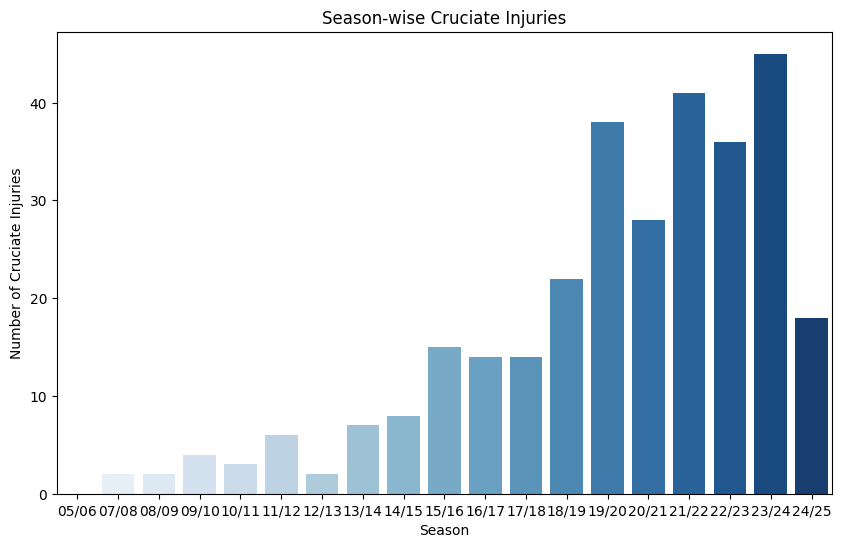

C:\Users\Furka\AppData\Local\Temp\ipykernel_14552\3911334630.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=league_injuries.index, y=league_injuries['Cruciate Injuries'], palette='Reds')


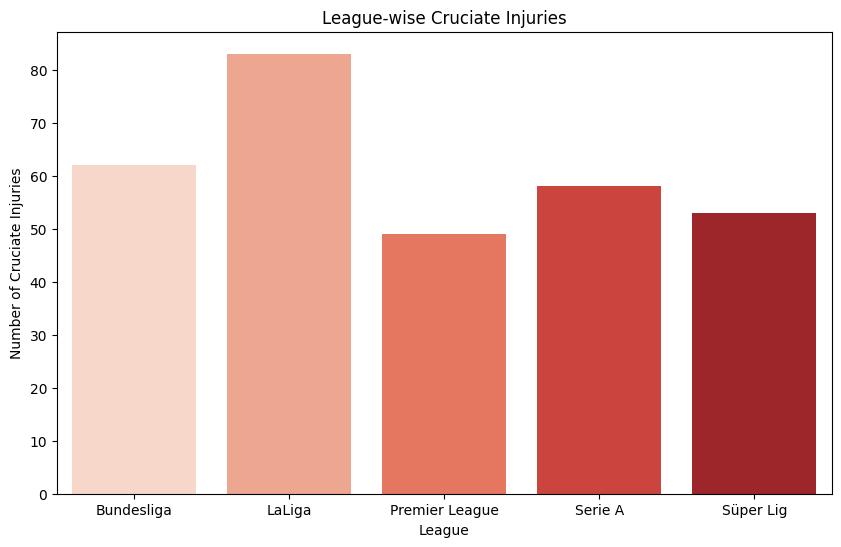


Summary Statistics for Cruciate Injuries:

       Player ID                           From  Days Out  Games Missed  \
count    9867.00                           9867   9867.00       9867.00   
mean   239454.17  2020-11-18 17:40:59.470963712     39.29          6.42   
min      3333.00            2006-05-26 00:00:00      0.00          1.00   
25%     93936.00            2019-03-28 00:00:00     11.00          2.00   
50%    197122.00            2021-04-01 00:00:00     22.00          4.00   
75%    341051.00            2023-02-02 00:00:00     42.00          7.00   
max   1292650.00            2024-11-29 00:00:00    873.00        151.00   
std    179711.82                            NaN     53.99          8.33   

       Appearances  Minutes Played  target  
count      9867.00         9867.00 9867.00  
mean         18.72          182.37    0.03  
min           0.00            0.00    0.00  
25%          10.00            1.00    0.00  
50%          20.00            2.00    0.00  
75%       

In [129]:
# Plot Season-based Injuries
plt.figure(figsize=(10, 6))
sns.barplot(x=season_injuries.index, y=season_injuries['Cruciate Injuries'], palette='Blues')
plt.title('Season-wise Cruciate Injuries')
plt.xlabel('Season')
plt.ylabel('Number of Cruciate Injuries')
plt.show()

# Plot League-based Injuries
plt.figure(figsize=(10, 6))
sns.barplot(x=league_injuries.index, y=league_injuries['Cruciate Injuries'], palette='Reds')
plt.title('League-wise Cruciate Injuries')
plt.xlabel('League')
plt.ylabel('Number of Cruciate Injuries')
plt.show()

# Summary statistics
print("\nSummary Statistics for Cruciate Injuries:\n")
print(data_top5_leagues.describe())

C:\Users\Furka\AppData\Local\Temp\ipykernel_14552\872658691.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=league_season_injuries.index, y=league_season_injuries[f'{league} Cruciate Injuries'], palette='Greens')


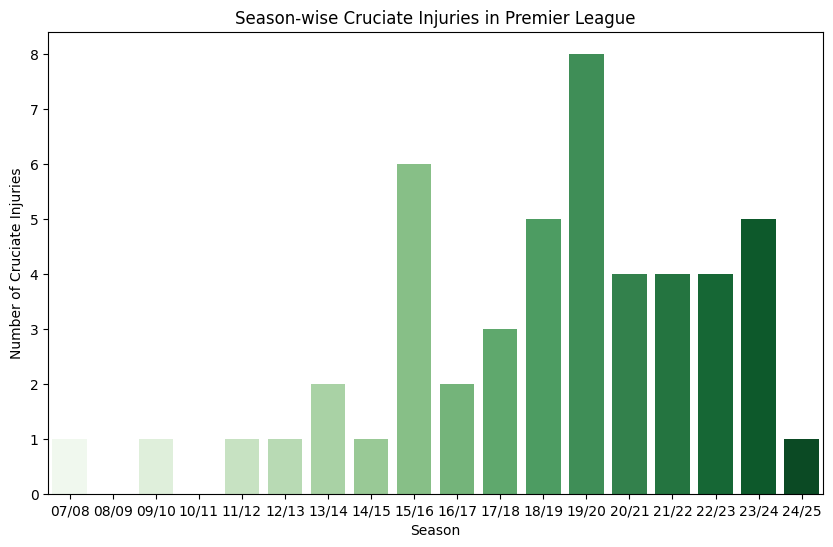

C:\Users\Furka\AppData\Local\Temp\ipykernel_14552\872658691.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=league_season_injuries.index, y=league_season_injuries[f'{league} Cruciate Injuries'], palette='Greens')


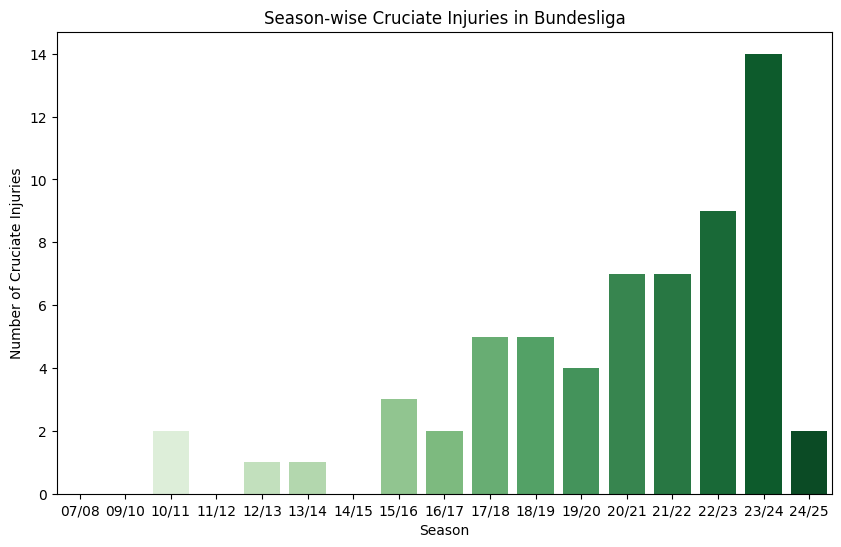

C:\Users\Furka\AppData\Local\Temp\ipykernel_14552\872658691.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=league_season_injuries.index, y=league_season_injuries[f'{league} Cruciate Injuries'], palette='Greens')


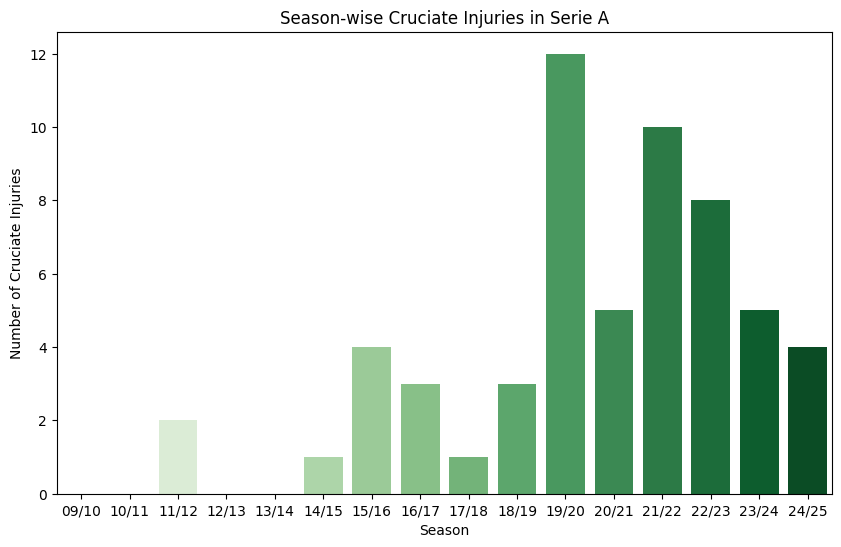

C:\Users\Furka\AppData\Local\Temp\ipykernel_14552\872658691.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=league_season_injuries.index, y=league_season_injuries[f'{league} Cruciate Injuries'], palette='Greens')


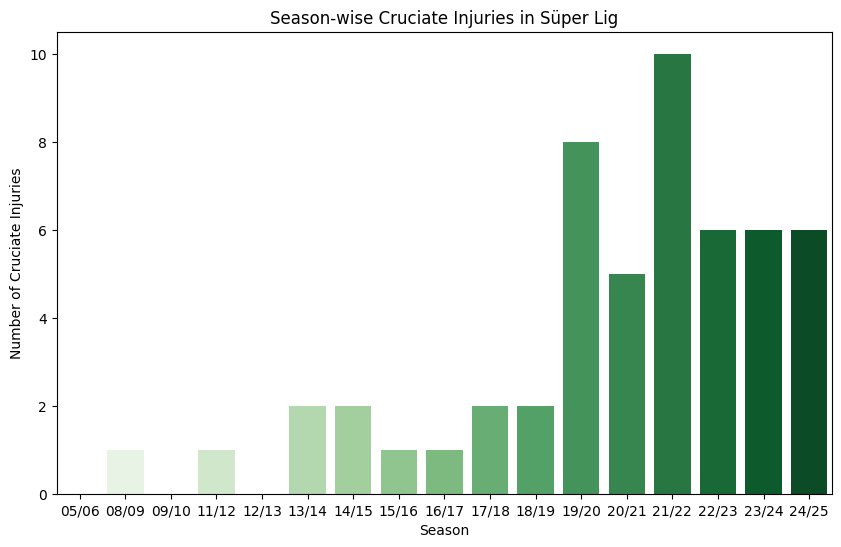

C:\Users\Furka\AppData\Local\Temp\ipykernel_14552\872658691.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=league_season_injuries.index, y=league_season_injuries[f'{league} Cruciate Injuries'], palette='Greens')


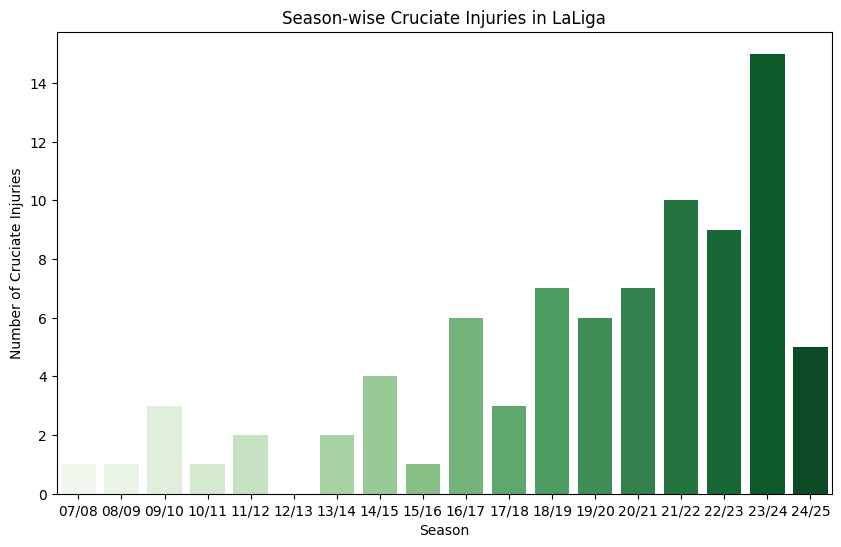

In [132]:

# Plot Season-wise Injuries for Top-5 Leagues
for league in top_leagues:
    league_season_injuries = data_top5_leagues[data_top5_leagues['League'] == league].groupby('Season').agg({
        'target': 'sum'
    }).rename(columns={
        'target': f'{league} Cruciate Injuries'
    })
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=league_season_injuries.index, y=league_season_injuries[f'{league} Cruciate Injuries'], palette='Greens')
    plt.title(f'Season-wise Cruciate Injuries in {league}')
    plt.xlabel('Season')
    plt.ylabel('Number of Cruciate Injuries')
    plt.show()
